The aim of this is to compare the variance of estimators of the gradient of our variational objective. This amounts to training a network for 10 and 100 epochs and comparing the variance of gradients with respect to weights in the top and bottom of the network.

The procedure used in the original paper is as follows:

* Train two networks for either 10 or 100 epochs, using either correlated or independent variational dropout.
* Either, add no noise or add adaptive noise or add noise via single weight samples or separate weight samples for every example in the Epoch.

There are also some quirks as to how to arrange the training set and the network architecture. All details will be in this notebook.

Training the networks
========

Training two networks, one using variational dropout A (correlated) and one using variational dropout B (independent). The architecture used in the paper:

* has four dense layers (including the output layer)
* uses rectified linear nonlinearities
* uses 1024 hidden units in each dense layer (apart from the output)
* uses per-weight alphas in the case of independent weight noise
* uses per-unit (in the input) alphas in the case of correlated weight noise

In [1]:
import varout.layers
import varout.objectives
import varout.experiments
import lasagne.layers
import lasagne.nonlinearities
import lasagne.init
import theano
import theano.tensor as T
import numpy as np
import holonets
import holoviews as hv
%load_ext holoviews.ipython

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 0: Tesla K40c (CNMeM is disabled)


Another quirk of the experiment is that they decided to merge the MNIST validation set into the training set; so we have to validation set:

In [2]:
dataset = varout.experiments.load_data()
dataset['X_train'] = np.vstack([dataset['X_train'],dataset['X_valid']])
dataset['y_train'] = np.hstack([dataset['y_train'],dataset['y_valid']])
print dataset['X_train'].shape

(60000, 784)


In [3]:
# load dataset as shared variable
dataset = holonets.monitor.enforce_shared(dataset, T.matrix, T.ivector)

Independent Weight Noise
---------------------

Starting with variational dropout B. For our results to match, we'll have to use a Normal initialisation of the weights; overriding that used by Lasagne:

In [115]:
rng = np.random.RandomState(42)
def salimans_sample(shape):
    w = rng.normal(0,1,(shape[0],shape[1]))
    w -= np.mean(w, axis=0, keepdims=True)
    w /= np.sqrt(np.sum(np.square(w), axis=0, keepdims=True))
    return w.astype(theano.config.floatX)

In [139]:
batch_size, input_dim, n_hidden, output_dim = 200, 784, 1024, 10
l_in = lasagne.layers.InputLayer((batch_size, input_dim))
l_hidden1 = lasagne.layers.DenseLayer(l_in, num_units=n_hidden, nonlinearity=lasagne.nonlinearities.rectify,
                                      W=salimans_sample)
l_drop1 = varout.layers.VariationalDropoutB(l_hidden1, p=0.2, adaptive='weightwise')
l_hidden2 = lasagne.layers.DenseLayer(l_drop1, num_units=n_hidden, nonlinearity=lasagne.nonlinearities.rectify,
                                      W=salimans_sample)
l_drop2 = varout.layers.VariationalDropoutB(l_hidden2, p=0.5, adaptive='weightwise')
l_hidden3 = lasagne.layers.DenseLayer(l_drop2, num_units=n_hidden, nonlinearity=lasagne.nonlinearities.rectify,
                                      W=salimans_sample)
l_drop3 = varout.layers.VariationalDropoutB(l_hidden3, p=0.5, adaptive='weightwise')
l_hidden4 = lasagne.layers.DenseLayer(l_drop3, num_units=output_dim,
                                      nonlinearity=lasagne.nonlinearities.softmax,
                                      W=salimans_sample)
l_out = varout.layers.VariationalDropoutB(l_hidden4, p=0.5, adaptive='weightwise')

In [140]:
def set_up_training(l_out, dataset, squash_updates=False, N_train=60000, N_test=10000):
    expressions = holonets.monitor.Expressions(l_out, dataset, update_rule=lasagne.updates.adam,
                                              loss_function=lasagne.objectives.categorical_crossentropy,
                                              loss_aggregate=T.mean, 
                                              extra_loss=-varout.objectives.priorKL(l_out)/N_train,
                                              learning_rate=0.001)
    # add channel to monitor loss and accuracy on training and test
    expressions.add_channel(**expressions.loss('train', False))
    expressions.add_channel(**expressions.accuracy('train', False))
    expressions.add_channel(**expressions.loss('test', True))
    expressions.add_channel(**expressions.accuracy('test', True))
    expressions.add_channel(name='cross-entropy loss', dimension='Loss',
                            expression=T.mean(
            lasagne.objectives.categorical_crossentropy(expressions.network_output, expressions.y_batch)),
                            function='train')
    expressions.add_channel(name='DKL', dimension='Loss', 
                            expression=-varout.objectives.priorKL(l_out)/N_train, function='train')
    # would like to track the various alphas
    for i, dlayer in enumerate([l for l in lasagne.layers.get_all_layers(l_out) 
                   if isinstance(l, varout.layers.VariationalDropout)]):
        expressions.add_channel(name='Dropout Layer {0} Mean Alpha'.format(i+1),
                                dimension='Alpha', function='train',
                                expression=T.mean(T.nnet.sigmoid(dlayer.logitalpha)))
        expressions.add_channel(name='Dropout Layer {0} Sigma Alpha'.format(i+1),
                                dimension='Alpha', function='train',
                                expression=T.sqrt(T.var(T.nnet.sigmoid(dlayer.logitalpha))))
    channels = expressions.build_channels()
    train = holonets.train.Train(channels, n_batches={'train': N_train//batch_size,
                                                      'test': N_test//batch_size})
    loop = holonets.run.EpochLoop(train, dimensions=train.dimensions)
    return loop

In [141]:
loop = set_up_training(l_out, dataset)

:NdLayout   [Channel]
   :Curve   [Epoch]   (Loss)
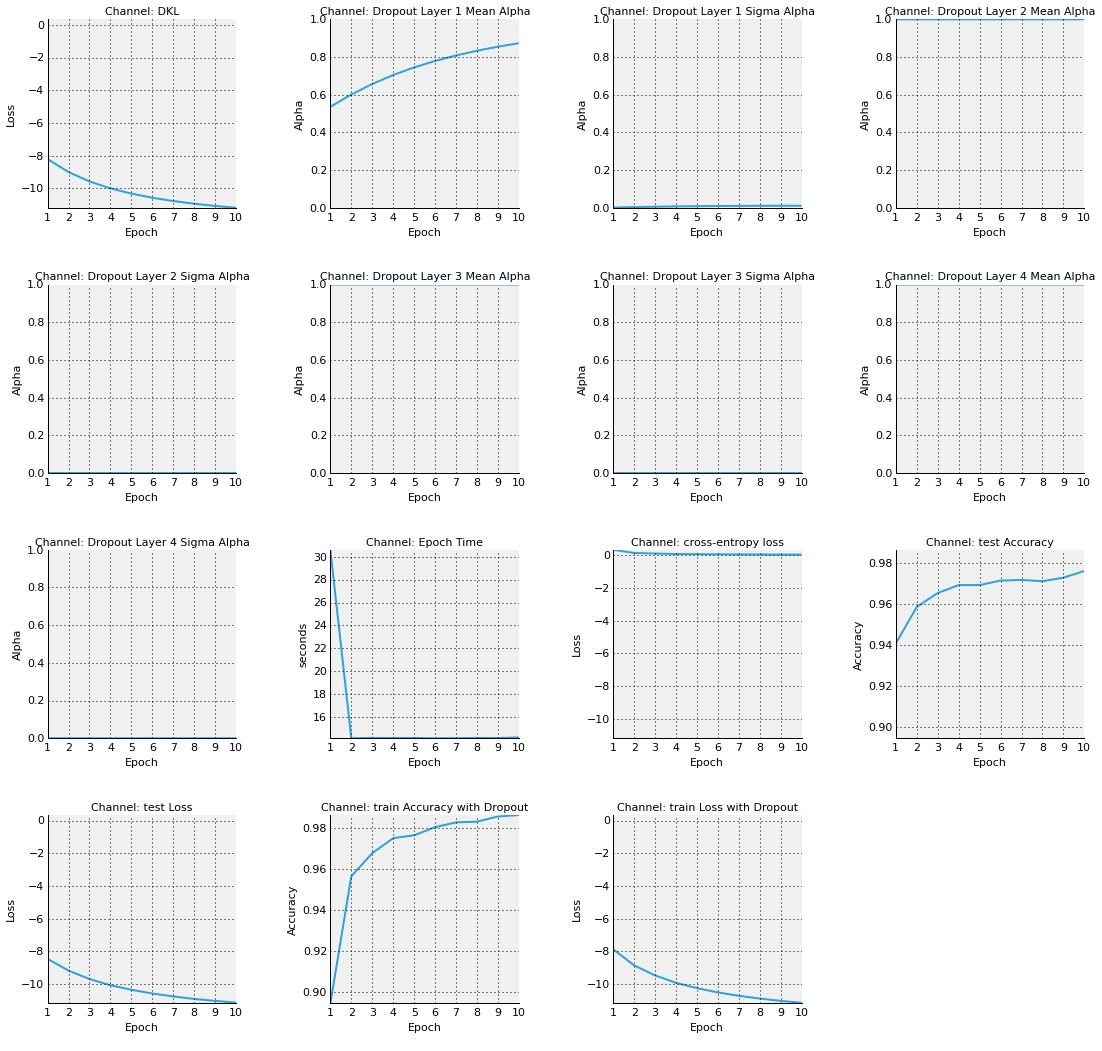

In [142]:
localA10 = loop.run(10)
localA10.layout('Channel')

Would actually like to see what kind of weight-wise variances we've learnt:

In [143]:
def wp_comparisons(l_out):
    all_layers = lasagne.layers.get_all_layers(l_out)
    hmap = hv.HoloMap(kdims=['Layer', 'Noise Variance/Weight'])
    for i in range(1,9,2):
        hmap[(i, 'Weight')] = hv.Image(all_layers[i].W.eval(), vdims=['Weight'])
        hmap[(i, 'Noise Variance')] = hv.Image(T.nnet.sigmoid(all_layers[i+1].logitalpha).eval(), vdims=['Alpha'])
    return hmap

In the first layer, we see that it's starting to learn to lower the variance in the center of the images to get more information about the digits:

:Layout
   .AdjointLayout.I    :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.II   :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.III  :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.IV   :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.V    :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.VI   :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.VII  :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.VIII :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.IX   :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.X    :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.XI   :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.XII  :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.XIII :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.XIV  :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.XV   :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.XVI  :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
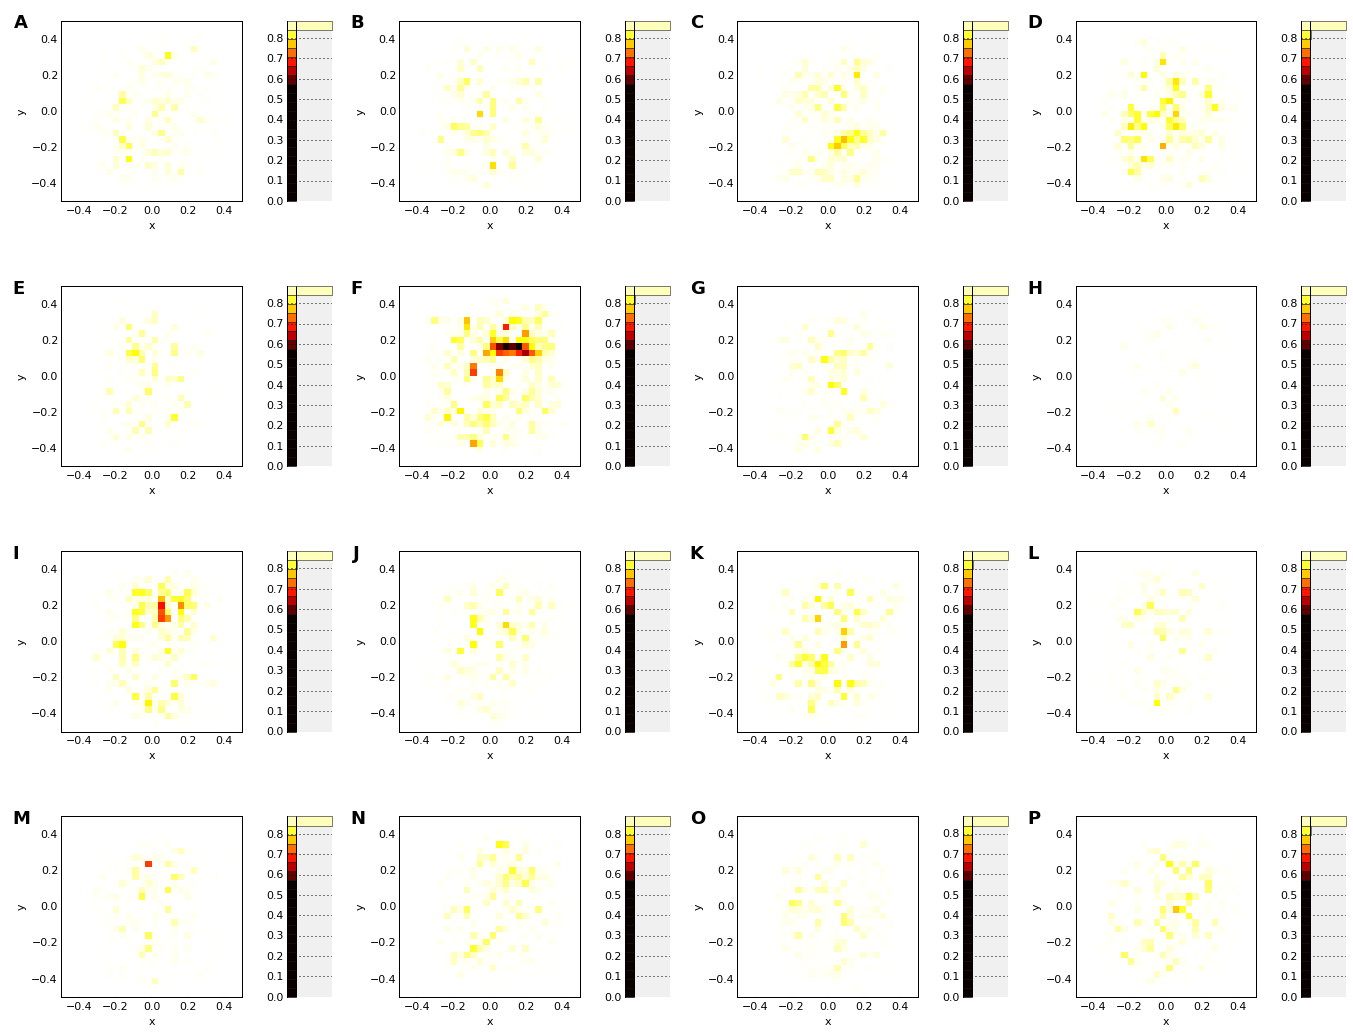

In [144]:
examples = []
for i in range(16):
    examples.append(hv.Image(T.nnet.sigmoid(l_drop1.logitalpha).eval()[:,i].reshape(28,28)).hist())
hv.Layout(examples)

However, in later layers this isn't true, it's just living with an effective dropout rate of 0.5:

:NdLayout   [Layer,Noise Variance/Weight]
   :Image   [x,y]   (Weight)
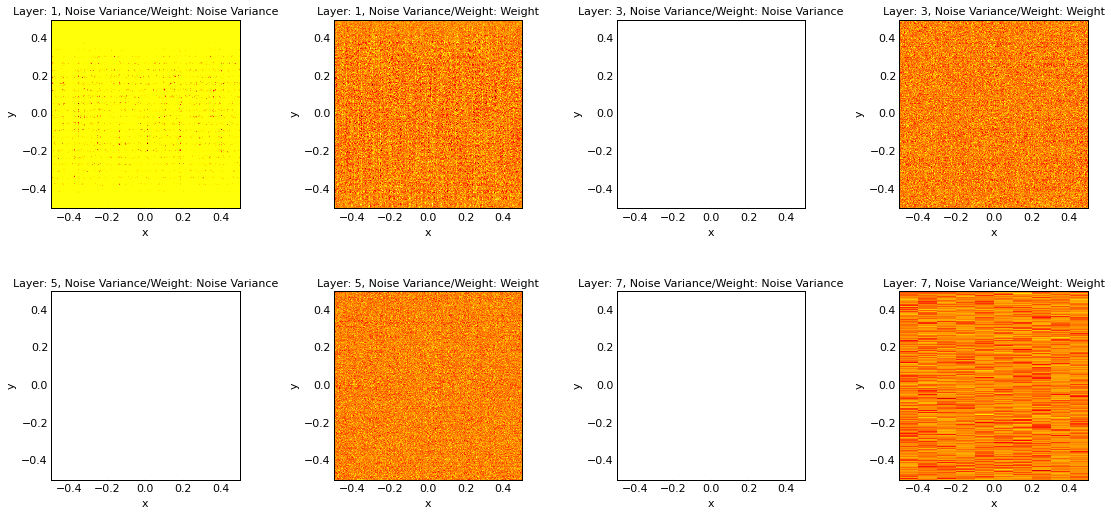

In [145]:
wp_comparisons(l_out).layout(['Layer', 'Noise Variance/Weight'])

In [35]:
def read_gradient_variance(l_out, dataset, batch_size, deterministic=False, N_train=60000):
    # monitor the gradient wrt top and bottom weight matrices:
    all_layers = [l for l in lasagne.layers.get_all_layers(l_out) 
                 if isinstance(l, lasagne.layers.DenseLayer)]
    bottom_dense = all_layers[0]
    top_dense = all_layers[-1]
    X_batch, y_batch = T.matrix('X'), T.ivector('y')
    netout = lasagne.layers.get_output(l_out, X_batch, deterministic=deterministic)
    lowerbound = T.mean(lasagne.objectives.categorical_crossentropy(netout, y_batch))\
        - varout.objectives.priorKL(l_out)/N_train
    bottom_grads = T.grad(lowerbound, bottom_dense.W)
    top_grads = T.grad(lowerbound, top_dense.W)
    # run this over the whole training set
    batch_index = T.iscalar('index')
    batch_slice = slice(batch_index*batch_size, (batch_index+1)*batch_size)
    eval_grads = theano.function([batch_index], [bottom_grads, top_grads], 
                                  givens={X_batch: dataset['X_train'][batch_slice],
                                          y_batch: dataset['y_train'][batch_slice]})
    bgrads = []
    tgrads = []
    n_batches = N_train//batch_size
    for i in range(n_batches):
        b,t = eval_grads(i)
        bgrads.append(np.array(b))
        tgrads.append(np.array(t))
    bgrads, tgrads = np.array(bgrads), np.array(tgrads)
    # take the variance along minibatches
    corrected_var = lambda x: ((N_train*(x-x.mean(axis=0)))**2).mean(axis=0)
    bvar, tvar = corrected_var(bgrads), corrected_var(tgrads)
    # then average this
    return np.mean(bvar), np.mean(tvar)

In [39]:
meangradients = {}
meangradients['indep bottom 10'], meangradients['indep top 10'] = read_gradient_variance(l_out, dataset, batch_size)
print "Mean Gradient variance at bottom layer: {0}".format(meangradients['indep bottom 10'])
print "Mean Gradient variance at top layer: {0}".format(meangradients['indep top 10'])

Mean Gradient variance at bottom layer: 606.809082031
Mean Gradient variance at top layer: 24272.2539062


Then we store these parameter values and continue training to 100 epochs:

In [13]:
indep10params = lasagne.layers.get_all_param_values(l_out)

CPU times: user 6min 56s, sys: 14min 10s, total: 21min 6s
Wall time: 21min 23s


:NdLayout   [Channel]
   :Curve   [Epoch]   (Loss)
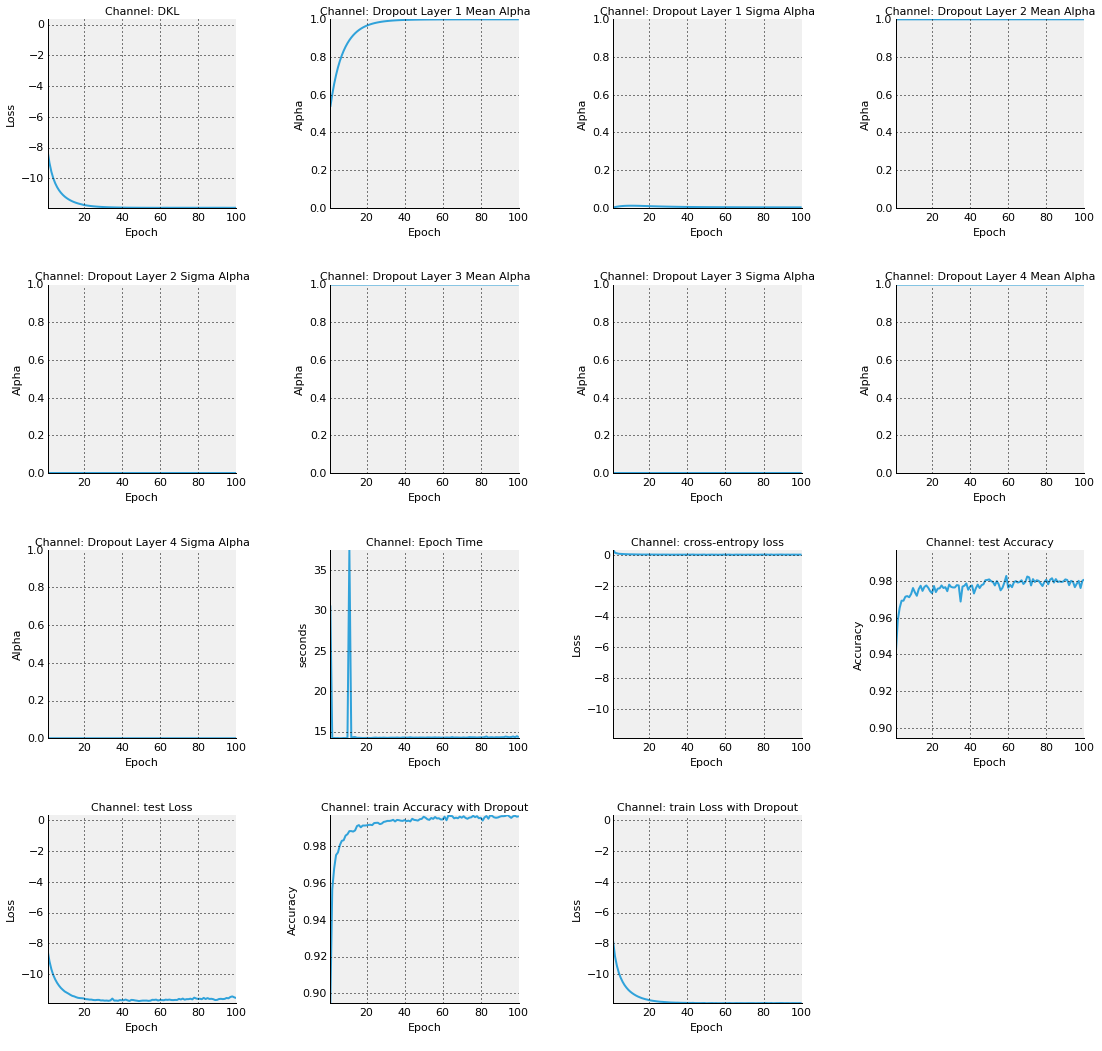

In [146]:
%%time
loop.run(90).layout('Channel')

:Layout
   .AdjointLayout.I    :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.II   :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.III  :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.IV   :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.V    :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.VI   :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.VII  :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.VIII :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.IX   :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.X    :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.XI   :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.XII  :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.XIII :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.XIV  :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.XV   :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
   .AdjointLayout.XVI  :AdjointLayout
      :Image   [x,y]   (z)
      :Histogram   [z]   (Frequency)
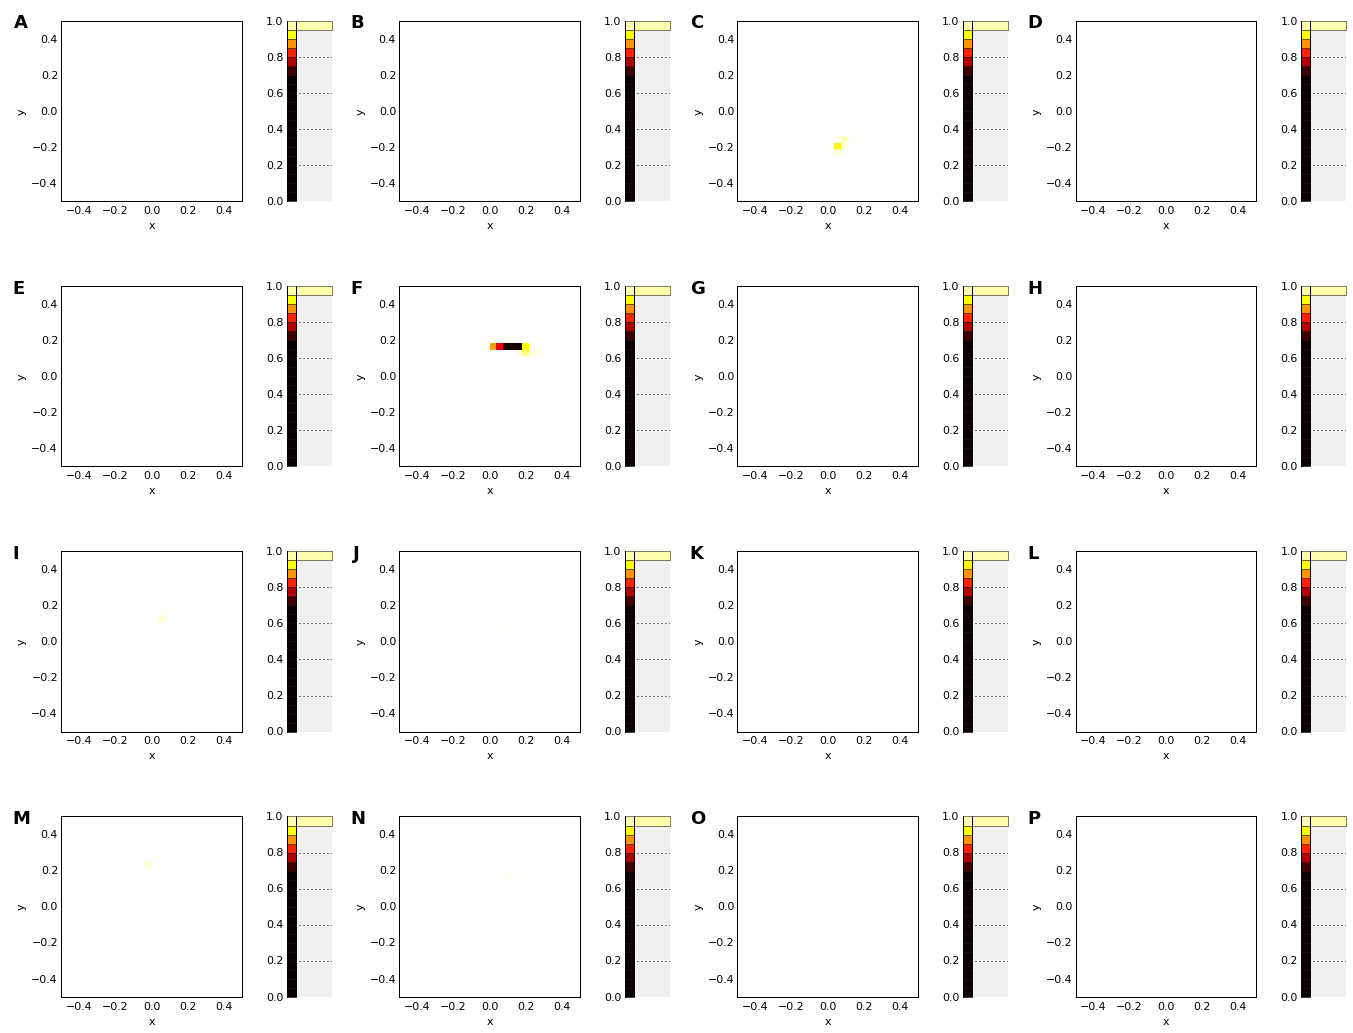

In [147]:
examples = []
for i in range(16):
    examples.append(hv.Image(T.nnet.sigmoid(l_drop1.logitalpha).eval()[:,i].reshape(28,28)).hist())
hv.Layout(examples)

:NdLayout   [Layer,Noise Variance/Weight]
   :Image   [x,y]   (Weight)
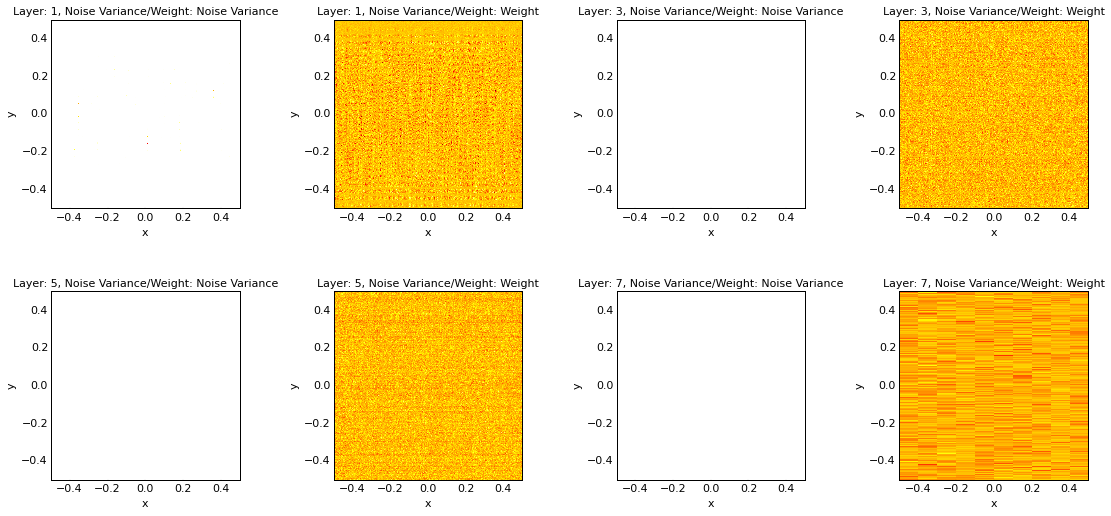

In [148]:
wp_comparisons(l_out).layout(['Layer', 'Noise Variance/Weight'])

Unfortunately, our variance has _increased_, rather than decreased with training. Could be due to the increase in noise added to the layers, but this should only affect the bottom layer.

In [41]:
lasagne.layers.set_all_param_values(l_out, indep100params)

In [42]:
meangradients['indep bottom 100'], meangradients['indep top 100'] = read_gradient_variance(l_out, dataset, batch_size)
print "Mean Gradient variance at bottom layer: {0}".format(meangradients['indep bottom 100'])
print "Mean Gradient variance at top layer: {0}".format(meangradients['indep top 100'])

Mean Gradient variance at bottom layer: 3004.08642578
Mean Gradient variance at top layer: 252553.90625


In [16]:
indep100params = lasagne.layers.get_all_param_values(l_out)

In [17]:
import pickle
import gzip
with gzip.open("indep_params.pkl.gz", "wb") as f:
    pickle.dump([indep10params, indep100params], f)

In [5]:
import pickle
import gzip
with gzip.open("indep_params.pkl.gz", "rb") as f:
    indep10params, indep100params = pickle.load(f)

No dropout noise
--------------

Can immediately run the variance calculation without noise by setting deterministic flag:

In [43]:
lasagne.layers.set_all_param_values(l_out, indep10params)

In [44]:
meangradients['no dropout bottom 10'], meangradients['no dropout top 10'] = \
    read_gradient_variance(l_out, dataset, batch_size, deterministic=True)
print "Mean Gradient variance at bottom layer: {0}".format(meangradients['no dropout bottom 10'])
print "Mean Gradient variance at top layer: {0}".format(meangradients['no dropout top 10'])

Mean Gradient variance at bottom layer: 545.391845703
Mean Gradient variance at top layer: 14605.1035156


In [45]:
lasagne.layers.set_all_param_values(l_out, indep100params)

In [46]:
meangradients['no dropout bottom 100'], meangradients['no dropout top 100'] = \
    read_gradient_variance(l_out, dataset, batch_size, deterministic=True)
print "Mean Gradient variance at bottom layer: {0}".format(meangradients['no dropout bottom 100'])
print "Mean Gradient variance at top layer: {0}".format(meangradients['no dropout top 100'])

Mean Gradient variance at bottom layer: 2712.58007812
Mean Gradient variance at top layer: 142557.28125


Single Weight Sample
------------------

In this case, we sample a single weight matrix and use that to propagate the minibatch. To do this, going to use the SingleWeightSample layer, which integrates a sampling procedure, and passing the weights from the network we just trained.

In [73]:
l_in = lasagne.layers.InputLayer((batch_size, input_dim))
l_hidden1 = varout.layers.SingleWeightSample(l_in, num_units=n_hidden, nonlinearity=lasagne.nonlinearities.rectify,
                                      W=salimans_sample)
l_hidden1.logitalpha = l_drop1.logitalpha
l_hidden2 = varout.layers.SingleWeightSample(l_hidden1, num_units=n_hidden, nonlinearity=lasagne.nonlinearities.rectify,
                                      W=salimans_sample)
l_hidden2.logitalpha = l_drop2.logitalpha
l_hidden3 = varout.layers.SingleWeightSample(l_hidden2, num_units=n_hidden, nonlinearity=lasagne.nonlinearities.rectify,
                                      W=salimans_sample)
l_hidden3.logitalpha = l_drop3.logitalpha
l_hidden4 = varout.layers.SingleWeightSample(l_hidden3, num_units=output_dim,
                                      nonlinearity=lasagne.nonlinearities.softmax,
                                      W=salimans_sample)
l_hidden4.logitalpha = l_out.logitalpha

In [74]:
single10params = [indep10params[i] for i in sorted(range(0,12,3)+range(1,12,3))]
single100params= [indep100params[i] for i in sorted(range(0,12,3)+range(1,12,3))]

In [75]:
lasagne.layers.set_all_param_values(l_hidden4, single10params)

In [76]:
meangradients['single sample bottom 10'], meangradients['single sample top 10'] = \
    read_gradient_variance(l_hidden4, dataset, batch_size)
print "Mean Gradient variance at bottom layer: {0}".format(meangradients['single sample bottom 10'])
print "Mean Gradient variance at top layer: {0}".format(meangradients['single sample top 10'])

Mean Gradient variance at bottom layer: 1461.41967773
Mean Gradient variance at top layer: 57979.6132812


In [77]:
lasagne.layers.set_all_param_values(l_hidden4, single100params)

In [78]:
meangradients['single sample bottom 100'], meangradients['single sample top 100'] = \
    read_gradient_variance(l_hidden4, dataset, batch_size)
print "Mean Gradient variance at bottom layer: {0}".format(meangradients['single sample bottom 100'])
print "Mean Gradient variance at top layer: {0}".format(meangradients['single sample top 100'])

Mean Gradient variance at bottom layer: 6838.15820312
Mean Gradient variance at top layer: 465339.75


Separate Weight Samples
---------------------

Now we sample a separate weight matrix for every input example. As you might expect, this is extremely slow.

In [79]:
l_in = lasagne.layers.InputLayer((1, input_dim))
l_hidden1 = varout.layers.SingleWeightSample(l_in, num_units=n_hidden, nonlinearity=lasagne.nonlinearities.rectify,
                                      W=salimans_sample)
l_hidden1.logitalpha = l_drop1.logitalpha
l_hidden2 = varout.layers.SingleWeightSample(l_hidden1, num_units=n_hidden, nonlinearity=lasagne.nonlinearities.rectify,
                                      W=salimans_sample)
l_hidden2.logitalpha = l_drop2.logitalpha
l_hidden3 = varout.layers.SingleWeightSample(l_hidden2, num_units=n_hidden, nonlinearity=lasagne.nonlinearities.rectify,
                                      W=salimans_sample)
l_hidden3.logitalpha = l_drop3.logitalpha
l_hidden4 = varout.layers.SingleWeightSample(l_hidden3, num_units=output_dim,
                                      nonlinearity=lasagne.nonlinearities.softmax,
                                      W=salimans_sample)
l_hidden4.logitalpha = l_out.logitalpha

In [80]:
lasagne.layers.set_all_param_values(l_hidden4, single10params)

Propagating single examples through means we can't use the above function, because we'll have to store 120,000 large matrices, which will fill up RAM, and because we have to build up batch gradient means from individual samples. So in this case, we'll just write some code to do the same thing again:

In [86]:
# speeding this up by doing the running averages in GPU memory
# inspired by Salimans code
from lasagne.utils import floatX
N_train, batch_size = 60000, 200
class Struct:
    pass
X_batch, y_batch = T.matrix('X'), T.ivector('y')
batch_index = T.iscalar('index')
batch_slice = slice(batch_index, (batch_index+1))
n_batches = N_train//batch_size
t,b = Struct(), Struct() # it's like a dictionary you can tab complete in a notebook...
for s in [t,b]:
    if s == b:
        l = l_hidden1
    elif s == t:
        l = l_hidden4
    s.mean = theano.shared(T.zeros_like(l.W).eval())
    s.batch_mean = theano.shared(T.zeros_like(l.W).eval())
    s.var = theano.shared(T.zeros_like(l.W).eval())
    s.netout = lasagne.layers.get_output(l_hidden4, X_batch)
    s.lowerbound = T.mean(lasagne.objectives.categorical_crossentropy(s.netout, y_batch))\
            - varout.objectives.priorKL(l_hidden4)/N_train
    s.grad = T.grad(s.lowerbound, l.W)
    s.moving_mean = theano.function([batch_index], [], 
                                    updates={s.mean: s.mean + floatX(1./N_train)*s.grad}, 
                                    givens={X_batch: dataset['X_train'][batch_slice],
                                            y_batch: dataset['y_train'][batch_slice]})
    s.moving_batch_mean = theano.function([batch_index], [], 
                                    updates={s.batch_mean: s.batch_mean + floatX(1./batch_size)*s.grad}, 
                                    givens={X_batch: dataset['X_train'][batch_slice],
                                            y_batch: dataset['y_train'][batch_slice]})
    s.moving_var = theano.function([], [], 
                       updates={s.var: s.var + floatX(1./n_batches)*T.square(floatX(N_train)*(s.batch_mean-s.mean))})

In [87]:
%%time
for i in range(N_train):
    for s in [t,b]:
        s.moving_mean(i)
for i in range(n_batches):
    for s in [t,b]:
        s.batch_mean.set_value(np.zeros_like(s.batch_mean.get_value()))
        for j in range(i*batch_size, (i+1)*batch_size):
            s.moving_batch_mean(j)
        s.moving_var()

meangradients['separate samples bottom 10'] = np.mean(b.var.get_value())
meangradients['separate samples top 10'] = np.mean(t.var.get_value())
print "Mean Gradient variance at bottom layer: {0}".format(meangradients['separate samples bottom 10'])
print "Mean Gradient variance at top layer: {0}".format(meangradients['separate samples top 10'])

Mean Gradient variance at bottom layer: 1236.53051758
Mean Gradient variance at top layer: 47891.2421875
CPU times: user 6min 17s, sys: 6min 22s, total: 12min 40s
Wall time: 12min 40s


In [89]:
lasagne.layers.set_all_param_values(l_hidden4, single100params)

In [90]:
for i in range(N_train):
    for s in [t,b]:
        s.moving_mean(i)
for i in range(n_batches):
    for s in [t,b]:
        s.batch_mean.set_value(np.zeros_like(s.batch_mean.get_value()))
        for j in range(i*batch_size, (i+1)*batch_size):
            s.moving_batch_mean(j)
        s.moving_var()

meangradients['separate samples bottom 100'] = np.mean(b.var.get_value())
meangradients['separate samples top 100'] = np.mean(t.var.get_value())
print "Mean Gradient variance at bottom layer: {0}".format(meangradients['separate samples bottom 100'])
print "Mean Gradient variance at top layer: {0}".format(meangradients['separate samples top 100'])

Mean Gradient variance at bottom layer: 8211.97558594
Mean Gradient variance at top layer: 487882.3125


Building Table
=====

Building a table of comparisons:

In [93]:
def get_variances(meangradients, estimator):
    return meangradients[estimator+" top 10"], meangradients[estimator+" bottom 10"],\
           meangradients[estimator+" top 100"], meangradients[estimator+" bottom 100"]

In [96]:
print " stochastic gradient estimator      | top 10 | bottom 10 | top 100 | bottom 100 "
print "------------------------------------|--------|-----------|---------|------------"
print "local reparameterization            | {:.2} | {:.2} | {:.2} | {:.2}".format(*get_variances(meangradients,
                                                                                                  "indep"))
print "separate weight samples             | {:.2} | {:.2} | {:.2} | {:.2}".format(*get_variances(meangradients,
                                                                                                  "separate samples"))
print "single weight sample                | {:.2} | {:.2} | {:.2} | {:.2}".format(*get_variances(meangradients,
                                                                                                  "single sample"))
print "no dropout                          | {:.2} | {:.2} | {:.2} | {:.2}".format(*get_variances(meangradients,
                                                                                                  "no dropout"))

 stochastic gradient estimator      | top 10 | bottom 10 | top 100 | bottom 100 
------------------------------------|--------|-----------|---------|------------
local reparameterization            | 2.4e+04 | 6.1e+02 | 2.5e+05 | 3e+03
separate weight samples             | 4.8e+04 | 1.2e+03 | 4.9e+05 | 8.2e+03
single weight sample                | 5.8e+04 | 1.5e+03 | 4.7e+05 | 6.8e+03
no dropout                          | 1.5e+04 | 5.5e+02 | 1.4e+05 | 2.7e+03


So clearly something is going wrong after 100 epochs, as the variance is rising for all examples then. After only 10 epochs the results match relatively closely the paper's results. At least, the order is correct.